# SAC-SVG(H): MBPO Experiments

This notebook reproduces Figure 2 of our [SAC-SVG(H) paper](https://arxiv.org/abs/2008.12775)
that considers the OpenAI gym locomotion tasks used
in MBPO (Janner et al., 2019).
Once setting up the code and a multitask environment with
hydra, you can launch 10 seeds using the best hyper-parameters
of SAC-SVG(H) with the command:

```bash
/train.py -m experiment=mbpo env=mbpo_cheetah,mbpo_hopper,mbpo_walker2d,mbpo_humanoid,mbpo_ant seed=$(seq -s, 10)
```

Then you can use this notebook as a starting point to analyze the
progress and results of these experiments.

In [1]:
%load_ext autoreload

import matplotlib.pyplot as plt
plt.style.use('bmh')

%autoreload 2
from svg.analysis import plot_exp, plot_ablation, sweep_summary
%matplotlib inline

In [2]:
# Load all of the experiments into dataframes for the experiments.
d = '../exp/2021.04.17/2048_mbpo/'
all_summary, groups, agg, configs = sweep_summary(d)

display(all_summary.head())
display(agg)

,env,seed,best_eval_rew,last_eval_rew,d,env_name
0,mbpo_cheetah,1,16490.721131,16211.209097,../exp/2021.04.17/2048_mbpo/0/,mbpo_cheetah
1,mbpo_cheetah,3,15814.255879,15037.872012,../exp/2021.04.17/2048_mbpo/2/,mbpo_cheetah
2,mbpo_cheetah,10,16241.069622,15590.255180,../exp/2021.04.17/2048_mbpo/9/,mbpo_cheetah
3,mbpo_hopper,2,4086.168831,2401.692851,../exp/2021.04.17/2048_mbpo/11/,mbpo_hopper
4,mbpo_cheetah,7,14560.622332,14172.839787,../exp/2021.04.17/2048_mbpo/6/,mbpo_cheetah


best_eval_rew              last_eval_rew  \
                                     mean          std          mean   
env_name      env                                                      
mbpo_ant      mbpo_ant        8288.696077  1183.103427   8163.550020   
mbpo_cheetah  mbpo_cheetah   14571.224437  2871.214498  13221.854430   
mbpo_hopper   mbpo_hopper     3917.269708   169.120880   3642.448877   
mbpo_humanoid mbpo_humanoid   9626.282362   774.896734   8062.065070   
mbpo_walker2d mbpo_walker2d   6028.896575   307.840072   5753.337798   

                                          
                                     std  
env_name      env                         
mbpo_ant      mbpo_ant       1312.316999  
mbpo_cheetah  mbpo_cheetah   3860.682656  
mbpo_hopper   mbpo_hopper     531.034875  
mbpo_humanoid mbpo_humanoid  2809.256164  
mbpo_walker2d mbpo_walker2d   647.904448

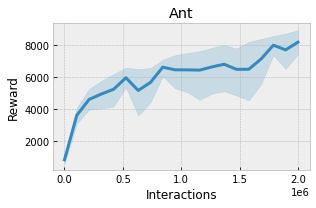

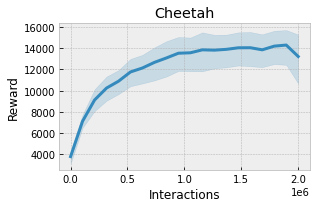

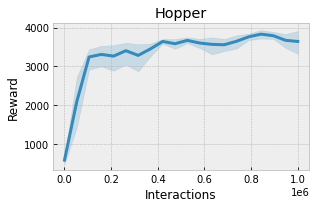

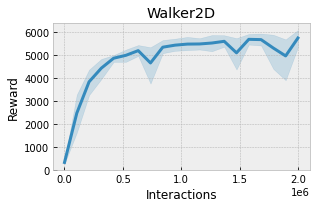

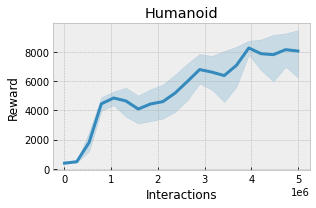

In [3]:
# Loop through and plot the aggregate results.
#
# These results are from our re-run of all of the experiments
# to make sure they are reproducable.

env_raws = ['mbpo_ant', 'mbpo_cheetah', 'mbpo_hopper', 'mbpo_walker2d', 'mbpo_humanoid']
for env in env_raws:
    I = (all_summary['env_name'] == env)
    t = all_summary[I]
    assert len(t) == 10 # Make sure we have all 10 seeds

    # Can append more directories for other ablations
    groups = []
    groups.append({'roots': t.d.values})

    env_pretty = env.split('_')[1].title()
    plot_ablation(
        groups = groups, 
        save=f'../data/fig/mbpo_{env}.pdf',
        title=env_pretty,
        legend=False,
    )

['experiment=mbpo', 'env=mbpo_humanoid', 'seed=3']


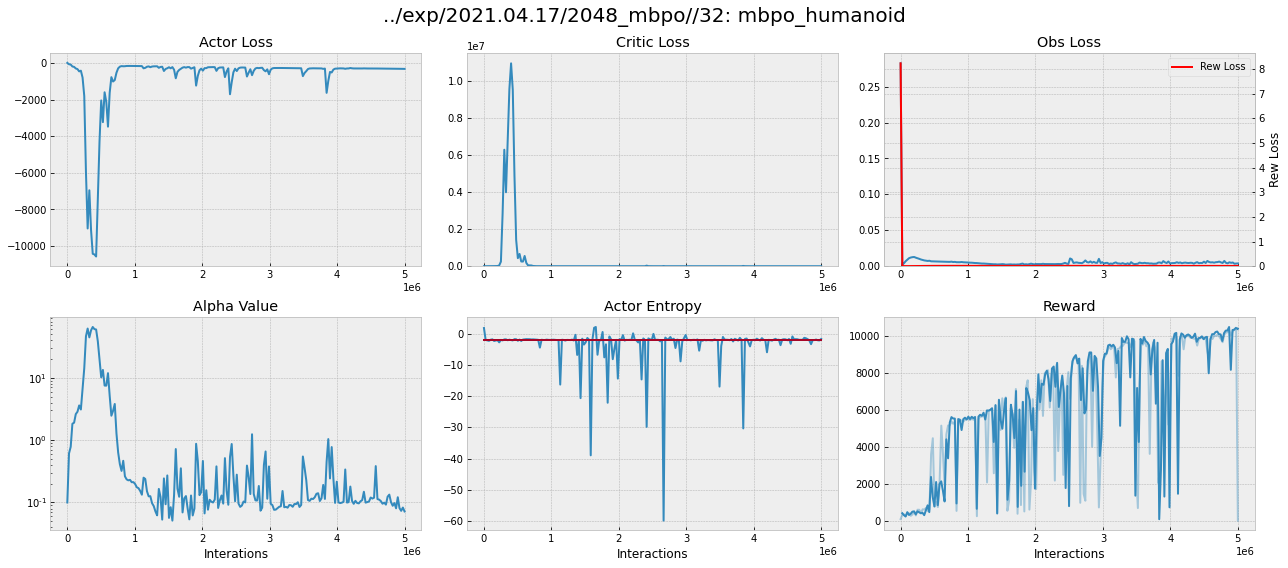

In [4]:
# You can also look at more of the details behind a single run with `plot_exp`:

d = '../exp/2021.04.17/2048_mbpo/'
plot_exp(f'{d}/32');